<a href="https://colab.research.google.com/github/WanPgui/ChatBot_Summative/blob/main/Chatbot(Creative_Writing_chatbot)_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to the Creative Writing Chatbot Model**

The chatbot is powered by a T5 Transformer model fine-tuned for creative writing tasks such as story generation, plot creation, and scene development. The model is trained on a large dataset of writing prompts and the first paragraph of the corresponding stories, enabling it to generate coherent and contextually appropriate stories based on the input it receives from the user.

With the powerful T5-small model based on TensorFlow, the model is fine-tuned to accept prompts normalized to "Write a story based on: [user input]." This preprocessing ensures training-inference consistency so that the chatbot is able to produce creative and diverse story responses.

The chatbot interface is designed with user-friendly features such as normalization of prompts, no repetitive output, and an interactive history log for tracking session dialogues. The system employs advanced decoding algorithms (beam search, no-repeat n-grams) to produce high-quality, creative text responses designed specifically for storytelling and fictional writing assistance.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# 1. Download **libraries**

In [ ]:
# 1. Install Required Libraries
!pip install transformers

In [ ]:
!pip install  datasets

In [ ]:
!pip install  scikit-learn

In [ ]:
!pip install  gradio

In [ ]:
!pip install  evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install  tensorflow

In [ ]:
!pip install datasets --quiet

In [ ]:
!pip install torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
!pip install pyarrow pandas --quiet

In [ ]:
# 2. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from datasets import load_dataset, Dataset
import gradio as gr
import random
import evaluate
import tensorflow as tf

# 2. Load **dataset**

In [ ]:

# Base path
base_path = "/content/drive/MyDrive/"

# Load Parquet files
df_train_part1 = pd.read_parquet(base_path + "train-00000-of-00002-105e07cb0d199464.parquet")
df_train_part2 = pd.read_parquet(base_path + "train-00001-of-00002-4fdb982c11056472.parquet")
df_val = pd.read_parquet(base_path + "validation-00000-of-00001-137b93e1e979d138.parquet")
df_test = pd.read_parquet(base_path + "test-00000-of-00001-16503b0c26ed00c6.parquet")

# Combine training splits
df_train = pd.concat([df_train_part1, df_train_part2], ignore_index=True)

# 3. **Data Preprocessing and Cleaning**

In [ ]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, create_optimizer
import tensorflow as tf
import pandas as pd
import os
from datasets import Dataset, DatasetDict

# ==== 1. Load and prepare data ====

# Parquet paths
train_path1 = "/content/drive/MyDrive/train-00000-of-00002-105e07cb0d199464.parquet"
train_path2 = "/content/drive/MyDrive/train-00001-of-00002-4fdb982c11056472.parquet"
test_path = "/content/drive/MyDrive/test-00000-of-00001-16503b0c26ed00c6.parquet"

# Read files
df1 = pd.read_parquet(train_path1)
df2 = pd.read_parquet(train_path2)
df_train = pd.concat([df1, df2], ignore_index=True)

# Drop rows with missing data
df_train = df_train.dropna(subset=["prompt", "story"])

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(df_train)

# Subset for fast testing
subset_size = min(5000, len(dataset))
dataset = dataset.select(range(subset_size))

# ==== 2. Extract and Normalize Inputs ====

def normalize_prompt(p):
    p = p.strip()
    if not p.lower().startswith("write a story based on:"):
        return "Write a story based on: " + p
    return p

prompt_inputs = []
prompt_outputs = []

for item in dataset:
    prompt = item.get('prompt', '').strip()
    story = item.get('story', '').strip()
    if isinstance(prompt, str) and isinstance(story, str) and prompt and story:
        prompt_inputs.append(normalize_prompt(prompt))
        first_paragraph = story.split("\n\n")[0].strip()
        prompt_outputs.append(first_paragraph)

# Check extracted data
print("Total prompts:", len(prompt_inputs))
print("Total outputs:", len(prompt_outputs))
if prompt_inputs:
    print("Sample prompt:", prompt_inputs[0])
    print("Sample output:", prompt_outputs[0])
else:
    raise ValueError("No valid prompt/story pairs found. Check dataset format.")

# ==== 3. Print status of loaded dataset ====

print("Hugging Face dataset loaded and sliced to:", subset_size)
print("Dataset sample row:")
print(dataset[0])

# ==== Optional: Prepare test dataset ====

df_test = pd.read_parquet(test_path)
if 'story' not in df_test.columns:
    df_test['story'] = ""

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})


Total prompts: 5000
Total outputs: 5000
Sample prompt: Write a story based on: [ WP ] You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . ''
Sample output: So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly. 
 It's funny, but I felt as if after gaining what I desired so long, what I have lived for my entire life, only then, when I achieved immortality I started truly aging. 
 
 5 world wars have passe

In [ ]:
print("Final prompts:", len(prompt_inputs))
print("Final outputs:", len(prompt_outputs))
print("Sample prompt:", prompt_inputs[0] if prompt_inputs else "None")
print("Sample output:", prompt_outputs[0] if prompt_outputs else "None")


Final prompts: 5000
Final outputs: 5000
Sample prompt: Write a story based on: [ WP ] You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . ''
Sample output: So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly. 
 It's funny, but I felt as if after gaining what I desired so long, what I have lived for my entire life, only then, when I achieved immortality I started truly aging. 
 
 5 world wars have passe

# 4. Tokenization, Optimization and **Training**

In [19]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, create_optimizer
import tensorflow as tf
import os

# === Force CPU (Important!) ===
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU use

# === 1. Load Model & Tokenizer ===
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# === 2. Tokenization Parameters ===
max_input_len = 256
max_target_len = 256

def tokenize_data(inputs, targets):
    input_enc = tokenizer(
        inputs,
        padding="max_length",
        truncation=True,
        max_length=max_input_len,
        return_tensors="tf"
    )
    target_enc = tokenizer(
        targets,
        padding="max_length",
        truncation=True,
        max_length=max_target_len,
        return_tensors="tf"
    )

    labels = tf.where(
        tf.math.equal(target_enc["input_ids"], tokenizer.pad_token_id),
        tf.constant(-100, dtype=tf.int32),
        target_enc["input_ids"]
    )

    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": labels
    }

# === 3. Clean and Tokenize ===
prompt_inputs = [str(p).strip() for p in prompt_inputs if isinstance(p, (str, bytes))]
prompt_outputs = [str(s).strip() for s in prompt_outputs if isinstance(s, (str, bytes))]

tokenized_data = tokenize_data(prompt_inputs, prompt_outputs)

# === 4. Train/Val Split ===
split_index = int(len(tokenized_data["input_ids"]) * 0.9)
train_data = {k: v[:split_index] for k, v in tokenized_data.items()}
val_data = {k: v[split_index:] for k, v in tokenized_data.items()}

# === 5. Create tf.data.Dataset ===
def to_tf_dataset(data, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": data["input_ids"],
            "attention_mask": data["attention_mask"]
        },
        data["labels"]
    ))
    if shuffle:
        ds = ds.shuffle(512)
    return ds.batch(4).prefetch(tf.data.AUTOTUNE)  # Smaller batch for CPU

train_ds = to_tf_dataset(train_data, shuffle=True)
val_ds = to_tf_dataset(val_data, shuffle=False)

# === 6. Optimizer and Scheduler ===
num_train_steps = len(train_ds) * 4
optimizer, lr_schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=300,
    num_train_steps=num_train_steps
)

model.compile(optimizer=optimizer)

# === 7. Train the Model (No Callbacks) ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    verbose=1
)


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


1125/1125 [==============================] - 13714s 12s/step - loss: 4.8682 - val_loss: 4.1758


# 5. Saving the **model**

In [20]:
model.save_pretrained("/content/t5_finetuned_wp")
tokenizer.save_pretrained("/content/t5_finetuned_wp")


('/content/t5_finetuned_wp/tokenizer_config.json',
 '/content/t5_finetuned_wp/special_tokens_map.json',
 '/content/t5_finetuned_wp/spiece.model',
 '/content/t5_finetuned_wp/added_tokens.json')

In [22]:
import numpy as np
from evaluate import load
from transformers import TFAutoModelForSeq2SeqLM, T5Tokenizer

#  Reload saved model
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/t5_finetuned_wp")
tokenizer = T5Tokenizer.from_pretrained("/content/t5_finetuned_wp")

# 1.  Text Generation Function
def generate_story(prompt_text, max_length=100):
    input_text = "Write a story based on: " + prompt_text
    input_ids = tokenizer.encode(input_text, return_tensors="tf", truncation=True)
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

#  Example Prompt
example_prompt = "You wake up in a world where the sun never sets."
generated_story = generate_story(example_prompt)
print("Prompt:\n", example_prompt)
print("\nGenerated Story:\n", generated_story)

# 2.  Save Model & Tokenizer
save_path = "/content/t5_finetuned_wp"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n Model saved to: {save_path}")

# 3. BLEU Evaluation on Validation Set
bleu = load("bleu")

# small sample for quick BLEU test
bleu_inputs = prompt_inputs[-20:]
bleu_targets = prompt_outputs[-20:]

bleu_preds = [generate_story(p) for p in bleu_inputs]
bleu_refs = [[t] for t in bleu_targets]

results = bleu.compute(predictions=bleu_preds, references=bleu_refs)
print("\n BLEU Score:", results["bleu"])


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/t5_finetuned_wp.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Prompt:
 You wake up in a world where the sun never sets.

Generated Story:
 You wake up in a world where the sun never sets. The sun isn't shining, but it's not going to change. I'm not sure if you're able to see what is going on in your life. You've been shivering around the world, and you have to be surrounded by the rays of the moon.

 Model saved to: /content/t5_finetuned_wp



 BLEU Score: 5.127987101100681e-07


In [23]:
!pip install evaluate seaborn scikit-learn matplotlib --quiet


# 6. Model prediction and analytics

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


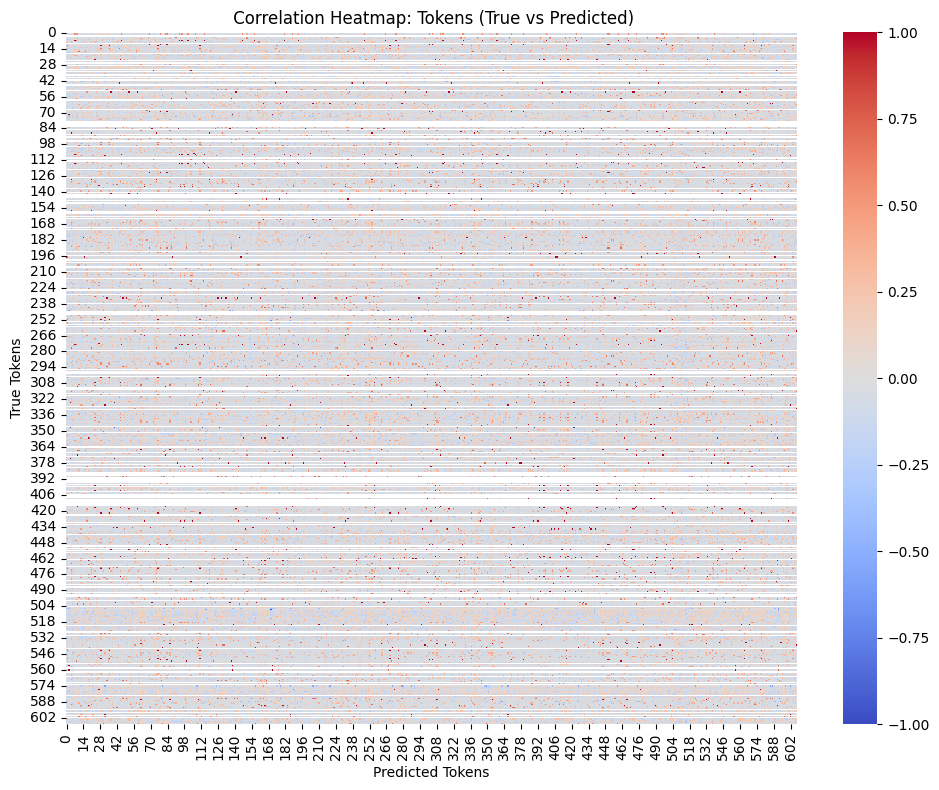

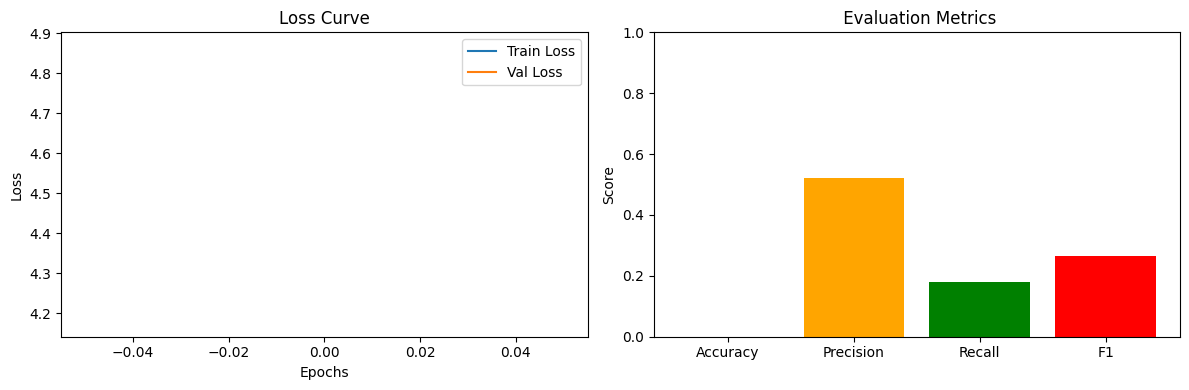


 Final Evaluation Metrics:
Accuracy      : 0.0000
Precision     : 0.5213
Recall        : 0.1783
F1 Score      : 0.2657


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from evaluate import load

# 1. Generate predictions and prepare references
bleu_inputs = prompt_inputs[-50:]
bleu_targets = prompt_outputs[-50:]

predictions = [generate_story(p) for p in bleu_inputs]
references = bleu_targets

# 2. Basic Accuracy
def exact_match(preds, refs):
    return np.mean([p.strip().lower() == r.strip().lower() for p, r in zip(preds, refs)])

accuracy = exact_match(predictions, references)

# 3. Convert to token-level binary vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True)

X_pred = vectorizer.fit_transform(predictions).toarray()
X_true = vectorizer.transform(references).toarray()

# Ensure same shape
min_len = min(X_pred.shape[1], X_true.shape[1])
X_pred = X_pred[:, :min_len]
X_true = X_true[:, :min_len]

# 4. Precision, Recall, F1 Score
precision = precision_score(X_true, X_pred, average='micro', zero_division=0)
recall = recall_score(X_true, X_pred, average='micro', zero_division=0)
f1 = f1_score(X_true, X_pred, average='micro', zero_division=0)

# 5. Correlation Heatmap of Token Overlap
correlation = np.corrcoef(X_true.T, X_pred.T)[:min_len, min_len:]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap="coolwarm", cbar=True)
plt.title(" Correlation Heatmap: Tokens (True vs Predicted)")
plt.xlabel("Predicted Tokens")
plt.ylabel("True Tokens")
plt.tight_layout()
plt.show()

# 6. Training History Plots (if available)
if 'history' in locals() or 'history' in globals():
    hist = history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()



    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy', 'Precision', 'Recall', 'F1'],
            [accuracy, precision, recall, f1],
            color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title(" Evaluation Metrics")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()
else:
    print(" Training history not captured — loss plot unavailable.")

# 7. Print Final Scores
print(f"\n Final Evaluation Metrics:")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")


In [25]:
!pip install rouge-score bert_score --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt  \
0  [ WP ] You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . ''\n   
1                                                                                                                                                                          [ WP ] The moon is actually a giant egg , and it has just started to hatch .\n   
2                                                                                          [ WP ] You find a rip in time walking through the alleys . You enter it to find yourself on a metal table with surgical instruments on a chair next to you .\n   
3         [ WP ] For years in your youth the same imaginary character appears in your dreams , you are good friends . Years later , when adult , you meet her in real life , she clearly recognises you and tries to avoid you , and you want answers .\n   
4                    [ WP ] You glance at your watch 10:34 am , roughly 10 seconds later your plane explodes over the Pacific Ocean . Your eyes open as you jolt awake . The familiar hum of the planes engine remains . Checking your watch it is 9:35\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

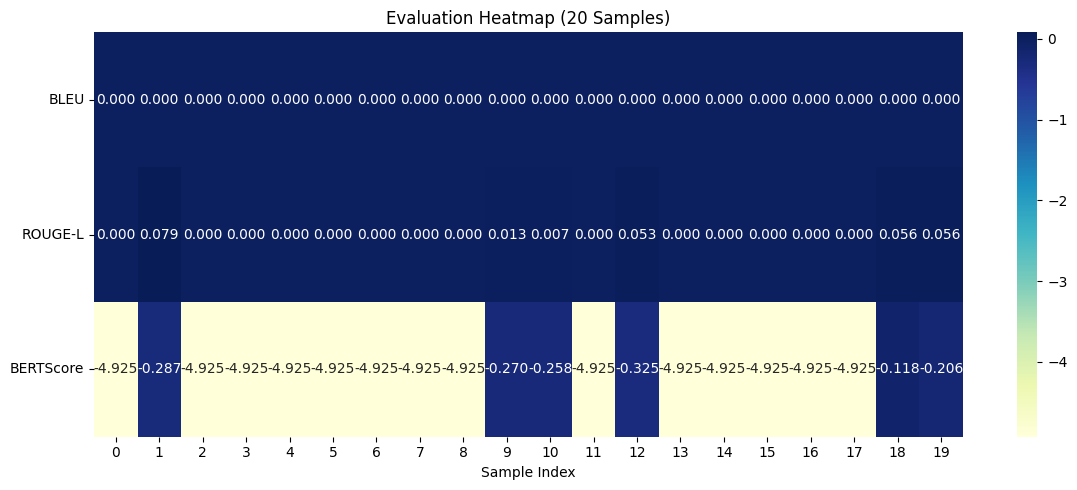

In [28]:
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bert_score import score as bert_score

# Load correct metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Sample 20 examples
sampled = dataset.select(range(20))
prompts = sampled["prompt"]
references = [s.strip().split("\n\n")[0] for s in sampled["story"]]

# Generate predictions
generated = []
for prompt in prompts:
    input_prompt = "Write a story based on: " + prompt
    input_ids = tokenizer(input_prompt, return_tensors="tf", truncation=True, max_length=128).input_ids
    output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    generated.append(output_text)

# Filter out empty predictions for BLEU
paired_data = [(gen, ref) for gen, ref in zip(generated, references) if gen.strip()]
filtered_generated = [item[0] for item in paired_data]
filtered_references = [item[1] for item in paired_data]

# BLEU score
bleu_scores = []
if filtered_generated:
    for ref, pred in zip(filtered_references, filtered_generated):
        score = bleu.compute(predictions=[pred], references=[[ref]])
        bleu_scores.append(score["bleu"])
else:
    print("Warning: No non-empty generated strings to compute BLEU on.")
    bleu_scores = [0] * len(generated)

# ROUGE score (handles empty strings)
rouge_scores = []
for ref, pred in zip(references, generated):
    score = rouge.compute(predictions=[pred], references=[ref])
    rouge_scores.append(score["rougeL"])

# BERTScore
P, R, F1 = bert_score(generated, references, lang="en", rescale_with_baseline=True)
bert_scores = F1.tolist()

# Create DataFrame with results
df = pd.DataFrame({
    "Prompt": prompts,
    "Reference": references,
    "Generated": generated,
    "BLEU": bleu_scores if len(bleu_scores) == len(generated) else [0] * len(generated),
    "ROUGE-L": rouge_scores,
    "BERTScore": bert_scores
})

# Display first few rows
pd.set_option('display.max_colwidth', None)
display(df.head())

# Heatmap visualization
score_matrix = df[["BLEU", "ROUGE-L", "BERTScore"]]
plt.figure(figsize=(12, 5))
sns.heatmap(score_matrix.T, cmap="YlGnBu", annot=True, fmt=".3f", cbar=True)
plt.title("Evaluation Heatmap (20 Samples)")
plt.yticks(rotation=0)
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


In [29]:
from IPython.display import display, HTML

# Show as rich HTML
display(HTML(df[["Prompt", "Reference", "Generated", "BLEU", "ROUGE-L", "BERTScore"]].to_html(escape=False)))


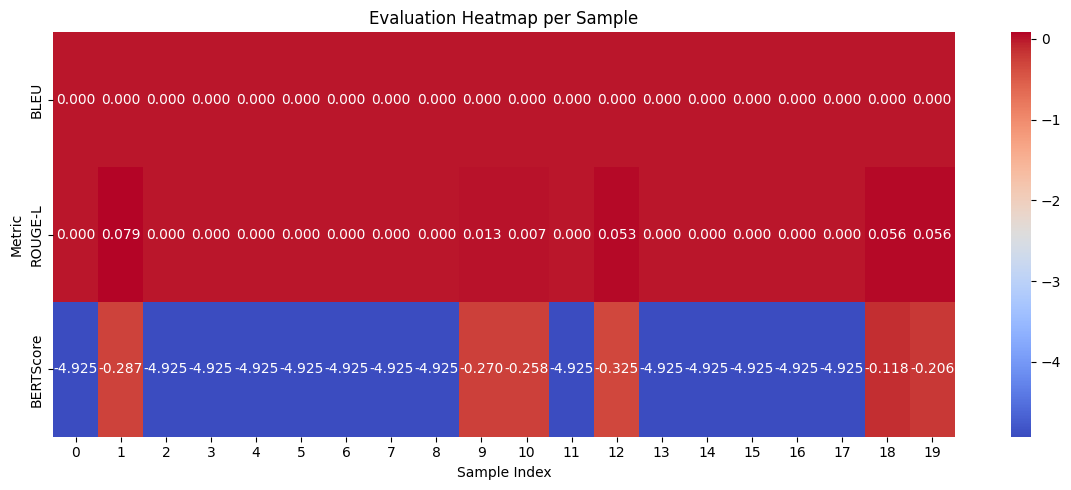

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(df[["BLEU", "ROUGE-L", "BERTScore"]].T, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Evaluation Heatmap per Sample")
plt.xlabel("Sample Index")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


In [38]:


# Print some training examples
for i in range(5):
    print(f"Prompt {i+1}: {prompt_inputs[i]}")
    print(f"First paragraph of story {i+1}:\n{prompt_outputs[i]}\n{'-'*40}\n")


Prompt 1: Write a story based on: [ WP ] You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . ''
First paragraph of story 1:
So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly. 
 It's funny, but I felt as if after gaining what I desired so long, what I have lived for my entire life, only then, when I achieved immortality I started truly aging. 
 
 5 world wars have passed, and now they feel like a simp

# 7. Web Interface- **Gradio**

In [34]:
import gradio as gr
from datetime import datetime

# Track history (in-memory)
history = []

# Keywords relevant to creative writing ONLY
known_keywords = ["story", "write", "writing", "fiction", "plot", "character", "scene", "dialogue", "novel", "short story", "narrative"]

MAX_LEN = 512  # Max input length for tokenizer

# Normalize prompt to match training
def normalize_prompt(p):
    p = p.strip()
    if not p.lower().startswith("write a story based on:"):
        return "Write a story based on: " + p
    return p

# Text generation function with improved generation and cleaning
def generate_response(user_input):
    if not any(keyword in user_input.lower() for keyword in known_keywords):
        return "I'm trained to help with creative writing. Please ask something related to storytelling or fiction."

    input_prompt = normalize_prompt(user_input)
    input_ids = tokenizer(input_prompt, return_tensors="tf", max_length=MAX_LEN, truncation=True).input_ids

    output_ids = model.generate(
        input_ids,
        max_length=150,
        do_sample=True,
        top_p=0.92,
        temperature=0.8,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        early_stopping=True
    )

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Remove repeated prompt from output
    if input_prompt.lower() in generated_text.lower():
        generated_text = generated_text.replace(input_prompt, "").strip()

    # Further clean known repeated structures
    for phrase in ["write a story based on:", "tell a story about:", "create a scene where"]:
        if generated_text.lower().startswith(phrase):
            generated_text = generated_text[len(phrase):].strip()

    # Save history with original user input
    history.append({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "prompt": user_input,
        "response": generated_text
    })

    return generated_text

# Function to export history
def export_history():
    return "\n\n".join([
        f"[{item['timestamp']}]\nPrompt: {item['prompt']}\nResponse: {item['response']}"
        for item in history
    ])

# Custom CSS
custom_css = """
body {
    background-color: #fff8f0;
    font-family: 'Segoe UI', sans-serif;
}
.gradio-container {
    border-radius: 20px;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
}
input, textarea {
    border-radius: 12px !important;
    padding: 10px !important;
    font-size: 16px !important;
    background-color: #ffffff;
    color: #000000;
}
"""

# Gradio Interface
with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## ✍️ Creative Writing Assistant")
    gr.Markdown("Ask for story ideas, writing help, or plot suggestions!")

    with gr.Row():
        input_box = gr.Textbox(lines=5, placeholder="Enter your story idea or question...", label="Your Prompt")
        output_box = gr.Textbox(label="Generated Story")

    generate_button = gr.Button("Generate Story")
    history_button = gr.Button("📜 View Session History")
    history_output = gr.Textbox(label="History Log", visible=False, lines=10)

    gr.Examples(
        examples=[
            ["Write a story about a girl who wakes up in a different timeline."],
            ["Tell a story about a detective solving a case with no clues."],
            ["Create a scene where two rivals are forced to work together."],
            ["Write a short story set during a blackout in a futuristic city."]
        ],
        inputs=input_box
    )

    generate_button.click(fn=generate_response, inputs=input_box, outputs=output_box)
    history_button.click(fn=export_history, outputs=history_output)
    history_button.click(fn=lambda: gr.update(visible=True), outputs=history_output)

# Launch app
demo.launch(debug=False, share=True)




Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://55ea361326dc4eb87a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [39]:
#Take first paragraph from training data (index 0)
input_text = prompt_outputs[0]  # the first paragraph text

generation_prompt = "Continue this story: " + input_text

# Tokenize input
input_ids = tokenizer(
    generation_prompt,
    return_tensors="tf",
    max_length=512,
    truncation=True
).input_ids

# Generate output (story continuation)
output_ids = model.generate(
    input_ids,
    max_length=150,
    num_beams=4,
    early_stopping=True,
    no_repeat_ngram_size=2
)

# Decode output
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("=== Input paragraph ===")
print(input_text)
print("\n=== Generated continuation ===")
print(generated_text)


=== Input paragraph ===
So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly. 
 It's funny, but I felt as if after gaining what I desired so long, what I have lived for my entire life, only then, when I achieved immortality I started truly aging. 
 
 5 world wars have passed, and now they feel like a simple sickeness that would pass by every so often, I could no longer evaluate the individual human as a being of its own, the importance of mortals is merely the same as the importance of my skin cells; They are a part of a mechanism so much more advanced, a mechanism that is so dear t

In [40]:
# Your input paragraph (as a string)
input_paragraph = """
So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly.
 It's funny, but I felt as if after gaining what I desired so long, what I have lived for my entire life, only then, when I achieved immortality I started truly aging.

 5 world wars have passed, and now they feel like a simple sickeness that would pass by every so often, I could no longer evaluate the individual human as a being of its own, the importance of mortals is merely the same as the importance of my skin cells; They are a part of a mechanism so much more advanced, a mechanism that is so dear to my fallen heart a mechanism that I have seen fall and rise so many times, a mechanism that when lost all of which it had, had me loosing my will to live, for the first time in all of my thousands years of existence.

 Acceptance, something so important. a skill that has proved itself worthy dozens of times, an ability that looks so easy to achieve, a gift, that I was n't able to aquire in all my years, until now. When the ashes on the ground flew into the now empty air upon humanity's fall, I felt as if all of it's weight was crushing me. Ignorance took over and I searched years for a hope, a sign of the very same patterns that I used to watch reappear every hundred years, the very core of my will to exist that was now no more that I so strongly wish was.

 If you have ever wondered if silence can drive people crazy, it can..
 I ca n't feel my legs, I have walked for days, just to hear the sound of gravel, crushed bones, crushed buildings and crushed civilizations under my steps to keep my sanity.. until I remembered, the day in my far past. The day of my rebirth, I took out of my pocket a small plastic box, with nine buttons and a small glass window. I could n't believe this was our past, I could n't believe how far we have been able to progress and yet, be destroyed by our own violence.
 I slowly dialed the number I was given, exactly 1729 years ago.

 I dropped a tear, a tear that was too slow to hit the ground as I got sucked into the darkness that emerged around me.

 A chill went through my spine as I saw my destiny rise above me, I could see the white teeth under the dark cloack...

 `` You have finally arrived'' He projected into my mind, with the most chilling cold and unhuman voice.

 `` I'm ready to obey'' I answered. I knew who was sitting infront of me, and it was time for me to obey him, after all these years of playing god, even I came to it.

 Funny is n't it? Even by achieving immortality, death, is inescapable.
"""

# Prepare prompt (add some guidance)
generation_prompt = "Continue this story: " + input_paragraph

# Tokenize input prompt
input_ids = tokenizer(
    generation_prompt,
    return_tensors="tf",
    max_length=512,
    truncation=True
).input_ids

# Generate continuation from model
output_ids = model.generate(
    input_ids,
    max_length=200,
    num_beams=4,
    early_stopping=True,
    no_repeat_ngram_size=2
)

# Decode generated tokens to text
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("=== Generated continuation ===\n")
print(generated_text)


=== Generated continuation ===

I walked on ruins, the remainings of places that I loved and got used to. I was able to feel the way I'm feeling my body. a skill that has proved itself worthy dozens of times, an ability that looks so easy to achieve. the importance of mortals is merely the same as the value of my skin cells. it's so much more important to me to live, and if you have ever wondered how silence can drive people crazy, it can.


In [41]:
import gradio as gr
from datetime import datetime

# Track history (in-memory)
history = []

MAX_LEN = 512  # Max length for tokenizer

# Text generation function with history saving
def generate_continuation(user_input):
    if not user_input.strip():
        return "Please enter a story paragraph to continue."

    # Prepare prompt for model
    input_prompt = "Continue this story: " + user_input.strip()

    # Tokenize input prompt
    input_ids = tokenizer(
        input_prompt,
        return_tensors="tf",
        max_length=MAX_LEN,
        truncation=True
    ).input_ids

    # Generate continuation
    output_ids = model.generate(
        input_ids,
        max_length=200,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Remove the input prompt part if repeated
    if generated_text.lower().startswith(input_prompt.lower()):
        generated_text = generated_text[len(input_prompt):].strip()

    # Save history
    history.append({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "input": user_input,
        "generated": generated_text
    })

    return generated_text

# Function to export history
def export_history():
    return "\n\n".join([
        f"[{item['timestamp']}]\nInput paragraph:\n{item['input']}\n\nGenerated continuation:\n{item['generated']}"
        for item in history
    ])

# Custom CSS for styling
custom_css = """
body {
    background-color: #fff8f0;
    font-family: 'Segoe UI', sans-serif;
}
.gradio-container {
    border-radius: 20px;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
}
input, textarea {
    border-radius: 12px !important;
    padding: 10px !important;
    font-size: 16px !important;
    background-color: #ffffff;
    color: #000000;
}
"""

with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## ✍️ Story Continuation Assistant")
    gr.Markdown("Paste your story paragraph below, and I'll continue the tale for you.")

    with gr.Row():
        input_box = gr.Textbox(lines=15, placeholder="Paste your story paragraph here...", label="Input Paragraph")
        output_box = gr.Textbox(label="Generated Continuation", lines=15)

    generate_button = gr.Button("Generate Continuation")
    history_button = gr.Button("📜 View Session History")
    history_output = gr.Textbox(label="History Log", visible=False, lines=10)

    generate_button.click(fn=generate_continuation, inputs=input_box, outputs=output_box)
    history_button.click(fn=export_history, outputs=history_output)
    history_button.click(fn=lambda: gr.update(visible=True), outputs=history_output)

demo.launch(debug=False, share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3707de77c31f719986.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
pip install nbformat

In [ ]:
pip install ipywidgets